### Isak Andersson AI23 - Maskininlärning
# Laboration

#### Uppgift 1 - Klassificering av hjärt- och kärlsjukdomar
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/cardio_train.csv', sep=';').drop('id', axis=1)

---
### 1. Introduction

This report focuses on the relation of BMI and blood pressure to the risk of being afflicted by a cardivascular disease, and aimed to prove their correlation by using machine-learning classification and regression models.

The data was cleaned, categorized and divided, to then be submitted for training and testing. This will ultimately show that while there are some correlating facotrs, none of the trained models are sufficient enough for a live use-case (>80% accuracy).

Lastely the discussion will try to answer why the models failed and why they seemed to reach about the same results.

#### 1.1 - Cleaning

Since the data originally contained outlandish and impossible datapoints, it was arbitrarily "cleaned" by the author as follows:

In [2]:
df = df.query('140 < height < 230')
df = df.query('40 < weight < 190')
df = df.query('60 < ap_hi < 250')
df = df.query('30 < ap_lo < 140')
df['age'] = (df['age'] / 365.25)
df = df.query('age > 35')
df = pd.get_dummies(columns=['gender'], data=df, drop_first=True, dtype=int, prefix='').rename(columns={'_2': 'male'})

- The height and weight limits was chosen solely to remove the end points of data. This was done since there's no real way to determine if there's any truth to the outliers, and thus, guessed. This, in some way or another, goes for the rest of the oulier eliminations aswell.
- The value limits for blood pressure (ap_hi (systolic) & ap_lo (diastolic)) was chosen after limited research found that the most extreme online [references](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1087497/) made the cut at 70 < ap_hi < 250, and 40 < ap_lo < 130. Therefore, in this report, the values are taken to even slightly lower/higher extremes to not miss out on valuable data.
- The age was made into years instead of the original days, and then also removed the very young outliers.
- The gender feature was also categorized as "1" and "2" for women and men respectivly. The piece of code above changes it to the standard binary format of "0" and "1". 

<details>

*<summary>Overview image of dataset (fig.1) </summary>*

<img src="data/cardio_overview.png" width="1400" height="650">

</details>

What is left of the original dataset is all but 1604 of the original 70000. See above fig for an overview of the distribution:

*(please see "slask.ipynb" for source code)*

#### 1.2 - Categorizing

On top of this initial clean, the weight, height and the blood pressure stats were re-configured to categorically show which BMI and blood pressure category the patient belongs to, as follows:

[BMI - wiki](https://en.wikipedia.org/wiki/Body_mass_index)
[Blood pressure - healthline](https://www.healthline.com/health/high-blood-pressure-hypertension#definition)

### $BMI = \frac{weight_{kg}}{height_m^2}$ 
<details>

*<summary> Image showing the categorical limits </summary>*

<img src="data/bp-cat.png" width="400" height="300"> <img src="data/bmi-cat.png" width="400" height="300">

</details>

*Please note that for this report no counts below "Normal weight" will be accounted for, and simply be removed from our working data. This based on wishes in the assignment. This removed abother ~1000 points of data.*

In [3]:
df['BMI'] = df['weight'] / (df['height'] / 100)**2 # Divided på 100 to convert cm to m.
df = df.query('BMI >= 18.5') # Removed underweight patients.

bmi_categories = pd.cut(df['BMI'], [18.5, 24.9, 29.9, 34.9, 40, np.inf], labels=['Normal weight', 'Overweight', 'Obese (class I)', 'Obese (class II)', 'Obese (class III)'])
bmi_categories = pd.get_dummies(bmi_categories, drop_first=False, dtype=int)
df = pd.concat([df, bmi_categories], axis=1)

# The pd.cut() function had trouble taking more than one column as input, which is why it is done in a "clunkier" way.
df['BP Healthy'] = ((df['ap_hi'] < 120) & (df['ap_lo'] < 80)).astype(int)
df['BP Elevated'] = ((df['ap_hi'] >= 120) & (df['ap_hi'] < 130) & (df['ap_lo'] < 80)).astype(int)
df['BP Hypertension (stage 1)'] = (((df['ap_hi'] >= 130) & (df['ap_hi'] < 140)) | ((df['ap_lo'] >= 80) & (df['ap_lo'] < 90))).astype(int)
df['BP Hypertension (stage 2)'] = ((df['ap_hi'] >= 140) | (90 <= df['ap_lo'])).astype(int)
df['BP Hypertensive Crisis'] = ((df['ap_hi'] >= 180) | (120 < df['ap_lo'])).astype(int)

---
### 2. Method

The data is divided up into two groups where both have the original data, but where one has the values that have been categorialized only as categories and the other only the continous values without the new categories.

In [4]:
df_copy = df.copy()
df_cat = df_copy.drop(['height', 'weight', 'ap_hi', 'ap_lo', 'BMI'], axis=1)
df_con = df_copy.drop(['weight', 'BP Healthy', 'BP Elevated', 'BP Hypertension (stage 1)', 'BP Hypertension (stage 2)','BP Hypertensive Crisis', 'Normal weight', 'Overweight', 'Obese (class I)', 'Obese (class II)', 'Obese (class III)'], axis=1)

The two datasets were checked for correlations and then submitted to the same list of classification models.

'Weight' was also removed from the continuous dataset since it correlated unnessacary close to 'BMI'.

---
### 3. Result

#### 3.1 - Correlation

The correlation matrix below shows an overall very gray color, which in this case means there's not a lot of correlation going on, at least not to the naked eye. The most significant correlations noticable with whether or not someone is afflicted by cardivascular disease is "age", "cholestorol" and the blood pressure categories of "Healthy" and "Hypertension (stage 2)", where none of these still aren't correlating very much.

The correlation-mapping also leaves out the features 'height', 'weight', 'ap_hi', 'ap_lo', 'BMI', as they have been repacked into categories as forementioned.

Other noticeable correlations are smoking to gender, glucose levels to cholestorol and the seemingly unimportant factor of physical activity ("active") to anything else!

Text(0.5, 1.0, 'Continuous features')

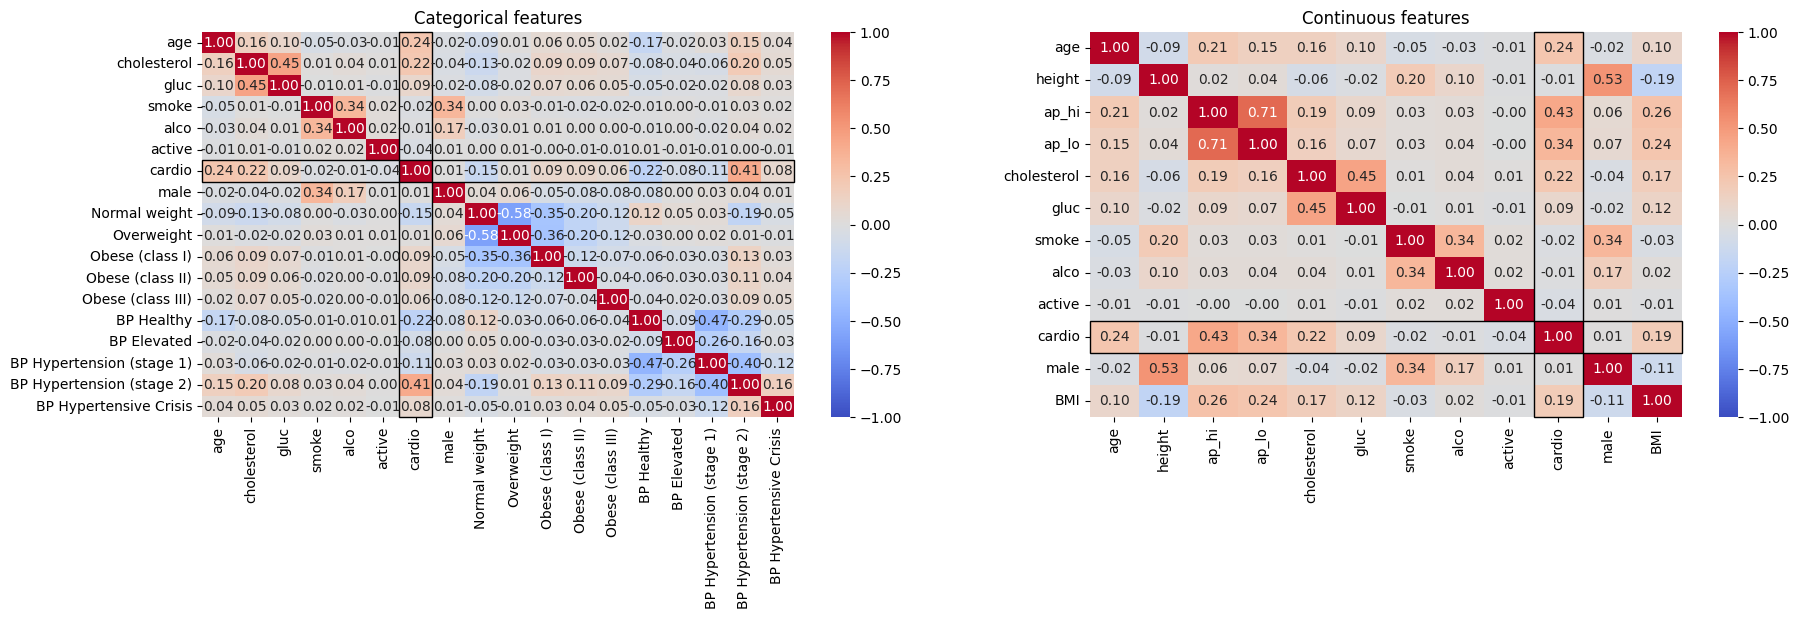

In [6]:
# https://stackoverflow.com/questions/62533046/how-to-add-color-border-or-similar-highlight-to-specifc-element-of-heatmap-in-py
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(1, 2, figsize=(21, 5))

sns.heatmap(df_cat.corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, ax=ax[0])
ax[0].add_patch(Rectangle((0, 6), len(df_cat.columns), 1, fill=False, edgecolor='black', lw=1, clip_on=False))
ax[0].add_patch(Rectangle((6, 0), 1, len(df_cat.columns), fill=False, edgecolor='black', lw=1, clip_on=False))

sns.heatmap(df_con.corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, ax=ax[1])
ax[1].add_patch(Rectangle((0, 9), len(df_con.columns), 1, fill=False, edgecolor='black', lw=1, clip_on=False))
ax[1].add_patch(Rectangle((9, 0), 1, len(df_con.columns), fill=False, edgecolor='black', lw=1, clip_on=False))


ax[0].set_title('Categorical features')
ax[1].set_title('Continuous features')

#### 3.2 - Training and optimization

The two datasets was divided into training and test data, where in both cases exacetly half of the data was used for each. Please note that a *random_state* was set when train/test plitting to make sure both the categorical and the continuous dataset used the same points of data when testing.

Six models were used, but as will be discussed in *5. Discussion* this did not matter as much as first thought.

The models were all cross validated an arbitrary amount of times, *cv=5*.

The six models tested on each of our two datasets were: *(and the short-hands used in code)*
- Logistic Regression *(log)*
- Stochastic Gradient Descent *(sgd)*
- K-Nearest Neighbor *(knn)*
- Random Forest *(rf)*
- Gradient Boosting *(gbc)*
- and Gaussian Naive Bayes *(nb)*

The parameters used were reached by manual trial and error without any specific starting point.

Shown below in code is the three that produced the most interesting results. Stochastic Gradient Descent, Random forrest and Gaussian Naive Bayes.

The parameters show below are also sifted somewhat from a much larger pool that was first tested. Please see *fig.2* in *4. Analasys* for more information.

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

scaler = MinMaxScaler()

X_cat, X_con, y = df_cat.drop(columns=['cardio'], axis=1), df_con.drop(columns=['cardio'], axis=1), df['cardio']

X_train_cat, X_test_cat, y_train, y_test = train_test_split(X_cat, y, test_size=0.5, random_state=16)
X_train_con, X_test_con, y_train, y_test = train_test_split(X_con, y, test_size=0.5, random_state=16)

pipe_sgd = make_pipeline(scaler, SGDClassifier())
pipe_rf = make_pipeline(RandomForestClassifier())
pipe_nb = make_pipeline(GaussianNB())

param_sgd = {'sgdclassifier__alpha': np.linspace(0.000001, 1, 8).astype(float), 'sgdclassifier__l1_ratio': np.linspace(0, 1, 11), 'sgdclassifier__loss': ['log_loss', 'modified_huber']}
param_rf = {'randomforestclassifier__n_estimators': np.linspace(1, 400, 50).astype(int)}
param_nb = {}

cv=5

def grid_search_fit(X, y, pipeline, param):
    grid_cv = GridSearchCV(pipeline, param, cv=cv, n_jobs=-1) # n_jobs=-1 uses all available cores. Remove at your own leasure.
    print(f"{grid_cv.fit(X, y).best_params_ = }")
    return grid_cv.fit(X, y)

In [12]:
y_pred_sgd_con = grid_search_fit(X_train_con, y_train, pipe_sgd, param_sgd).predict(X_test_con)
y_pred_rf_con = grid_search_fit(X_train_con, y_train, pipe_rf, param_rf).predict(X_test_con)
y_pred_nb_con = grid_search_fit(X_train_con, y_train, pipe_nb, param_nb).predict(X_test_con)

y_pred_sgd_cat = grid_search_fit(X_train_cat, y_train, pipe_sgd, param_sgd).predict(X_test_cat)
y_pred_rf_cat = grid_search_fit(X_train_cat, y_train, pipe_rf, param_rf).predict(X_test_cat)
y_pred_nb_cat = grid_search_fit(X_train_cat, y_train, pipe_nb, param_nb).predict(X_test_cat)

grid_cv.fit(X, y).best_params_ = {'sgdclassifier__alpha': 1e-06, 'sgdclassifier__l1_ratio': 0.8, 'sgdclassifier__loss': 'log_loss'}
grid_cv.fit(X, y).best_params_ = {'randomforestclassifier__n_estimators': 310}
grid_cv.fit(X, y).best_params_ = {}
grid_cv.fit(X, y).best_params_ = {'sgdclassifier__alpha': 0.14285799999999998, 'sgdclassifier__l1_ratio': 0.30000000000000004, 'sgdclassifier__loss': 'modified_huber'}
grid_cv.fit(X, y).best_params_ = {'randomforestclassifier__n_estimators': 9}
grid_cv.fit(X, y).best_params_ = {}


---
### 4. Analasys

Presented below is the predicted test data based on the corresponding training data from the two datasets.

The best model for classifying healthy patients as healthy (0-0 in the confusion matrix) is the gradient descent method (SGD). But since there's an argument to be made that it's more important for a doctor to be right about a sick person being sick (1-1) and maybe more so to be able to not misslabel a sick person as healthy (1-0), the model to be chosen will be the one with the highest recall for guessing afflicted patients.

This happens to be the random forest classifier when used on the continuous data. But it still only classifies sick people as healthy 30% ($1-0.7$) of the time, which of course is still not optimal.

The honoroble mention here is Naive Bayes that seems to be clear about whether or not someone is healthy, but not if they are sick. This very much like the SGD method, just slightly worse.

<details>

*<summary>Confusion matrix for all six models (fig. 2), and corresponding pipelines</summary>*

<img src="data/all-six-models.png">

`scaler = MinMaxScaler()`

`X_cat, X_con, y = df_cat.drop(columns=['cardio'], axis=1), df_con.drop(columns=['cardio'], axis=1), df['cardio']`

`X_train_cat, X_test_cat, y_train, y_test = train_test_split(X_cat, y, test_size=0.5, random_state=16)`

`X_train_con, X_test_con, y_train, y_test = train_test_split(X_con, y, test_size=0.5, random_state=16)`

`pipe_log = make_pipeline(scaler, LogisticRegression(max_iter=10000, solver='saga'))`

`pipe_sgd = make_pipeline(scaler, SGDClassifier())`

`pipe_knn = make_pipeline(scaler, KNeighborsClassifier())`

`pipe_rf = make_pipeline(RandomForestClassifier())`

`pipe_gbc = make_pipeline(GradientBoostingClassifier())`

`pipe_nb = make_pipeline(GaussianNB())`

`param_log = {'logisticregression__C': np.linspace(0.1, 10, 20).astype(float), 'logisticregression__penalty': ['l1', 'l2']}`

`param_sgd = {'sgdclassifier__alpha': np.linspace(0.000001, 1, 8).astype(float), 'sgdclassifier__l1_ratio': np.linspace(0, 1, 11), 'sgdclassifier__loss': ['log_loss', 'modified_huber']}`

`param_knn = {'kneighborsclassifier__n_neighbors': np.linspace(1, 60, 60).astype(int)}`

`param_rf = {'randomforestclassifier__n_estimators': np.linspace(1, 400, 50).astype(int)}`

`param_gbc = {'gradientboostingclassifier__n_estimators': np.linspace(1, 400, 50).astype(int)}`

which gave us best parameters of:

Continuous dataset:

`grid_cv.fit(X, y).best_params_ = {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'}`

`grid_cv.fit(X, y).best_params_ = {'sgdclassifier__alpha': 1e-06, 'sgdclassifier__l1_ratio': 1.0, 'sgdclassifier__loss': 'log_loss'}`

`grid_cv.fit(X, y).best_params_ = {'kneighborsclassifier__n_neighbors': 53}`

`grid_cv.fit(X, y).best_params_ = {'randomforestclassifier__n_estimators': 359}`

`grid_cv.fit(X, y).best_params_ = {'gradientboostingclassifier__n_estimators': 253}`

Categorical dataset:

`grid_cv.fit(X, y).best_params_ = {'logisticregression__C': 8.957894736842105, 'logisticregression__penalty': 'l1'}`

`grid_cv.fit(X, y).best_params_ = {'sgdclassifier__alpha': 0.14285799999999998, 'sgdclassifier__l1_ratio': 0.6000000000000001, 'sgdclassifier__loss': 'modified_huber'}`

`grid_cv.fit(X, y).best_params_ = {'kneighborsclassifier__n_neighbors': 55}`

`grid_cv.fit(X, y).best_params_ = {'randomforestclassifier__n_estimators': 9}`

`grid_cv.fit(X, y).best_params_ = {'gradientboostingclassifier__n_estimators': 196}`

Naive Bayes being excluded because no parameters were searched and thus no parameters are "best".
</details>

classification_report for Random Forest (continuous data):
              precision    recall  f1-score   support

           0       0.71      0.73      0.72     17138
           1       0.71      0.70      0.71     16794

    accuracy                           0.71     33932
   macro avg       0.71      0.71      0.71     33932
weighted avg       0.71      0.71      0.71     33932



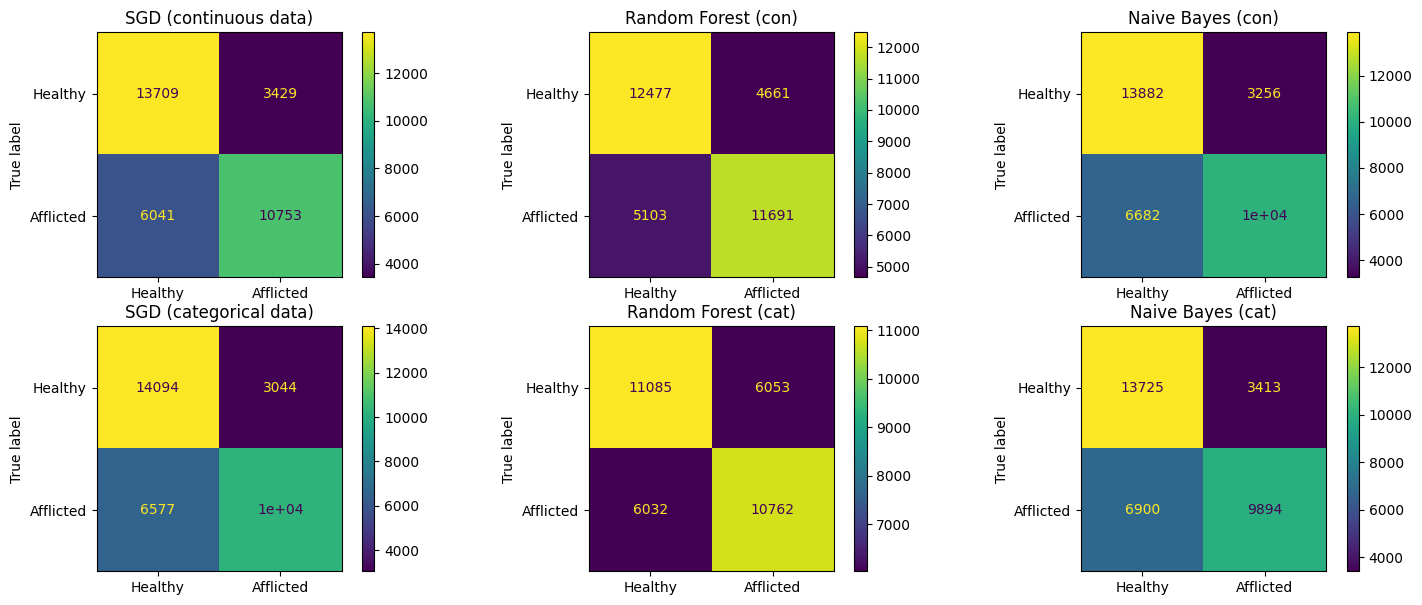

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print('classification_report for Random Forest (continuous data):')
print(classification_report(y_test, y_pred_rf_con))

ax, fig = plt.subplots(2, 3, figsize=(18, 7))

for i, ax in zip([y_pred_sgd_con, y_pred_rf_con, y_pred_nb_con,y_pred_sgd_cat, y_pred_rf_cat, y_pred_nb_cat], fig.flatten()):
    ConfusionMatrixDisplay(confusion_matrix(y_test, i), display_labels=['Healthy', 'Afflicted']).plot(ax=ax)

labels = ['SGD (continuous data)', 'Random Forest (con)', 'Naive Bayes (con)', 'SGD (categorical data)', 'Random Forest (cat)', 'Naive Bayes (cat)',]
for i, ax in enumerate(fig.flatten()):
    ax.set_title(labels[i])
    ax.set_xlabel('') # To save space

#### 4.1 - Testing

In [14]:
import joblib

joblib.dump(grid_search_fit(X_train_con, y_train, pipe_rf, param_rf), 'data/rfcon_model.pkl')

grid_cv.fit(X, y).best_params_ = {'randomforestclassifier__n_estimators': 334}


['data/rfcon_model.pkl']

The model is exported and tested on a small sample of 100 patient from our original (cleaned) dataset of the same sort, in this case the continuous dataset.

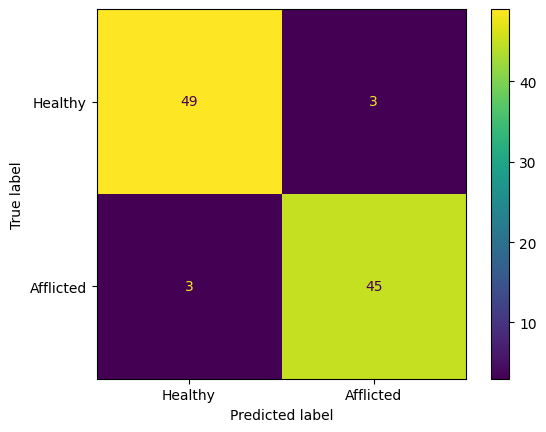

In [19]:
sample = df_con.sample(100)

X, y = sample.drop(columns=['cardio'], axis=1), sample['cardio']

chosen_model = joblib.load('data/rfcon_model.pkl')

ConfusionMatrixDisplay(confusion_matrix(y, chosen_model.predict(X)), display_labels=['Healthy', 'Afflicted']).plot()

By running the above cell a few time our exported model seem to guess wrong (afflicted as healthy and healthy as afflicted) between 1-10 times respectively out of 100.

---
### 5. Discussion

It is safe to say that not any of the models presented here will be used by medical proffesionals any time soon.

The models tested for this dataset never really came close, and they all seem to vary a lot each time you run them. This would suggest that there's a high bias and that the models are somewhat underfitted. This could perhaps be modified by introducing some complexity, by for example expanding the feature engineering somewhat or expand the cross-validation parameters even more. This was not done in this assignment because of the time each pass already take (take a look at the difference of each *best_parameter_* at the end of *3. Method*, the span is huge! Introducing more and wider validation-parameters would, according to this author, not be worth the potential small benefit), and the feature engineering is as is because of the assignment parameters.

But how come so many models had such similar result?

One could argue there's some data-leakage, especially between (within) the XOR categories (BMI and blood pressure). But then again if so, there should be a bigger differance between how the models worked on each type of dataset. Even so, there should've probably been another pass done to the feature-engineering aspect to better the results.

Furthermore, there's almost guaranteed some hyperparameter tuning that could've been done, but the lack of appropriate skills and intuition by the author made those findings espescially hard to find. He welcomes any suggestement and/or poointer in a better direction!

Ultimately the model chosen was the best for not miss-labeling afflicted patients as healthy. *But*, the variance is big enough for it to come out a completely different way if *Run All* in the top of the screen would be hit a couple of times. This was somewhat handled by having a *random_state* set, but setting it to more than just the train/test data would rather hinder the models of real accuracy rather than fishing for lucky pots. So on top of the train/test, most of the models chosen work in some stochastic way or another and could've used a random state as well, but the choice was made not to.

The point being, do not trust the model.